In [13]:
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import random

DATA_PATH = Path("../data/processed/snippets.npz")
EMBED_OUT_PATH = Path("../data/processed/autoencoder_embeddings.npz")

In [14]:
# ---------------------
# Dataset & utilities
# ---------------------

class MelodySnippetsDataset(Dataset):
    def __init__(self, intervals, indices):
        """
        intervals: np.ndarray of shape (N, L)
        indices: np.ndarray of snippet indices to use for this split
        """
        self.intervals = intervals
        self.indices = np.array(indices, dtype=int)

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        i = self.indices[idx]
        seq = self.intervals[i]  # shape (L,)
        # return as tensor of token ids
        return torch.tensor(seq, dtype=torch.long)


def load_data_and_build_vocab(data_path=DATA_PATH):
    data = np.load(data_path, allow_pickle=True)
    intervals = data["intervals"]  # (N, L)
    song_ids = data["song_ids"]
    # durations = data["durations"]  # not used yet
    midi_filenames = data.get("midi_filenames", None)

    # Map raw interval values (can be negative) to token ids [0..V-1]
    min_interval = intervals.min()
    max_interval = intervals.max()
    shifted_intervals = intervals - min_interval  # now in [0..(max-min)]

    vocab_size = int(max_interval - min_interval + 1)

    return shifted_intervals, song_ids, midi_filenames, min_interval, vocab_size


def split_by_song(song_ids, train_frac=0.7, val_frac=0.15, seed=42):
    """
    Split songs (by unique song_id) into train/val/test.
    Returns three arrays of snippet indices: train_idx, val_idx, test_idx.
    """
    rng = np.random.default_rng(seed)
    unique_songs = np.unique(song_ids)
    rng.shuffle(unique_songs)

    n_songs = len(unique_songs)
    n_train = int(train_frac * n_songs)
    n_val = int(val_frac * n_songs)

    train_songs = unique_songs[:n_train]
    val_songs = unique_songs[n_train:n_train + n_val]
    test_songs = unique_songs[n_train + n_val:]

    def idx_for(songs_subset):
        mask = np.isin(song_ids, songs_subset)
        return np.where(mask)[0]

    train_idx = idx_for(train_songs)
    val_idx = idx_for(val_songs)
    test_idx = idx_for(test_songs)

    return train_idx, val_idx, test_idx

In [20]:
# ---------------------
# Autoencoder model
# ---------------------

# class MelodyAutoencoder(nn.Module):
#     def __init__(self, vocab_size, embed_dim=64, hidden_dim=128, num_layers=1):
#         super().__init__()
#         self.embed = nn.Embedding(vocab_size, embed_dim)
#         self.encoder_rnn = nn.GRU(embed_dim, hidden_dim, num_layers=num_layers, batch_first=True)
#         self.decoder_rnn = nn.GRU(embed_dim, hidden_dim, num_layers=num_layers, batch_first=True)
#         self.output_fc = nn.Linear(hidden_dim, vocab_size)

#     def encode(self, x):
#         """
#         x: (batch, L) token ids
#         returns: (batch, hidden_dim) embedding
#         """
#         emb = self.embed(x)  # (B, L, E)
#         _, h_n = self.encoder_rnn(emb)  # h_n: (num_layers, B, H)
#         # take last layer
#         h_last = h_n[-1]  # (B, H)
#         return h_last

#     def decode(self, z, target_seq):
#         """
#         z: (batch, H) encoder embedding
#         target_seq: (batch, L) token ids, used with teacher forcing
#         returns logits: (batch, L, vocab_size)
#         """
#         B, L = target_seq.shape
#         # repeat z as initial hidden state
#         h0 = z.unsqueeze(0)  # (1, B, H)
#         # teacher forcing: feed ground-truth tokens as inputs
#         emb = self.embed(target_seq)  # (B, L, E)
#         out, _ = self.decoder_rnn(emb, h0)  # (B, L, H)
#         logits = self.output_fc(out)  # (B, L, V)
#         return logits

#     def forward(self, x):
#         """
#         Autoencoder forward: encode then decode with teacher forcing.
#         """
#         z = self.encode(x)
#         logits = self.decode(z, x)
#         return logits, z

class MelodyAutoencoder(nn.Module):
    def __init__(self, vocab_size, embed_dim=64, hidden_dim=128, num_layers=1):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.encoder_rnn = nn.GRU(embed_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.decoder_rnn = nn.GRU(embed_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.output_fc = nn.Linear(hidden_dim, vocab_size)

        # Learned start token for the decoder
        self.start_token = nn.Parameter(torch.zeros(1, 1, embed_dim))

    def encode(self, x):
        emb = self.embed(x)
        _, h_n = self.encoder_rnn(emb)
        return h_n[-1]  # (B, H)

    def decode(self, z, seq_len):
        """
        z: (B, H)
        seq_len: int (L)
        Decoder only gets z + a learned start vector, not the target tokens.
        """
        B = z.size(0)
        h0 = z.unsqueeze(0)              # (1, B, H)

        # Repeat a learned start embedding L times as input
        # shape: (B, L, E)
        start_emb = self.start_token.expand(B, seq_len, -1)

        out, _ = self.decoder_rnn(start_emb, h0)  # (B, L, H)
        logits = self.output_fc(out)              # (B, L, V)
        return logits

    def forward(self, x):
        z = self.encode(x)
        L = x.shape[1]
        logits = self.decode(z, L)
        return logits, z



In [21]:
# ---------------------
# Training loop
# ---------------------

def train_autoencoder(
    batch_size=64,
    num_epochs=10,
    lr=1e-3,
    device=None,
):
    intervals, song_ids, midi_filenames, min_interval, vocab_size = load_data_and_build_vocab()

    train_idx, val_idx, test_idx = split_by_song(song_ids)

    print(f"Total snippets: {intervals.shape[0]}")
    print(f"Train/Val/Test sizes: {len(train_idx)}, {len(val_idx)}, {len(test_idx)}")
    print(f"Interval vocab size: {vocab_size}, min_interval={min_interval}")

    train_ds = MelodySnippetsDataset(intervals, train_idx)
    val_ds = MelodySnippetsDataset(intervals, val_idx)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    model = MelodyAutoencoder(vocab_size=vocab_size, embed_dim=64, hidden_dim=128)
    model.to(device)

    criterion = nn.CrossEntropyLoss()  # will apply over vocabulary at each timestep
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    def run_epoch(loader, train=True):
        if train:
            model.train()
        else:
            model.eval()
        total_loss = 0.0
        n_tokens = 0

        for batch in loader:
            batch = batch.to(device)  # (B, L)
            optimizer.zero_grad()
            with torch.set_grad_enabled(train):
                logits, _ = model(batch)  # logits: (B, L, V)
                B, L, V = logits.shape
                loss = criterion(logits.view(B * L, V), batch.view(B * L))
                if train:
                    loss.backward()
                    optimizer.step()
            total_loss += loss.item() * B * L
            n_tokens += B * L

        return total_loss / n_tokens

    train_losses = []
    val_losses = []

    for epoch in range(1, num_epochs + 1):
        train_loss = run_epoch(train_loader, train=True)
        val_loss   = run_epoch(val_loader, train=False)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        print(f"Epoch {epoch:02d} | train_loss={train_loss:.4f} | val_loss={val_loss:.4f}")

    # After training, compute embeddings for all snippets (train+val+test)
    model.eval()
    all_embeddings = []

    full_ds = MelodySnippetsDataset(intervals, np.arange(intervals.shape[0]))
    full_loader = DataLoader(full_ds, batch_size=batch_size, shuffle=False)

    with torch.no_grad():
        for batch in full_loader:
            batch = batch.to(device)
            z = model.encode(batch)  # (B, H)
            all_embeddings.append(z.cpu().numpy())

    all_embeddings = np.vstack(all_embeddings)  # (N, H)
    print("All embeddings shape:", all_embeddings.shape)

    # Save everything we need for retrieval
    EMBED_OUT_PATH.parent.mkdir(parents=True, exist_ok=True)
    np.savez_compressed(
        EMBED_OUT_PATH,
        embeddings=all_embeddings,
        song_ids=song_ids,
        min_interval=min_interval,
        vocab_size=vocab_size,
        midi_filenames=midi_filenames,
    )
    print(f"Saved autoencoder embeddings to {EMBED_OUT_PATH}")
    print("Test indices (for later evaluation) length:", len(test_idx))

    # Return indices and losses for convenience if called from notebook
    return {
        "train_idx": train_idx,
        "val_idx": val_idx,
        "test_idx": test_idx,
        "min_interval": min_interval,
        "vocab_size": vocab_size,
        "train_losses": train_losses,
        "val_losses": val_losses,
    }


In [22]:
# ---------------------
# Retrieval using embeddings
# ---------------------

def load_embeddings(embed_path=EMBED_OUT_PATH):
    data = np.load(embed_path, allow_pickle=True)
    embeddings = data["embeddings"]   # (N, H)
    song_ids = data["song_ids"]
    midi_filenames = data.get("midi_filenames", None)
    return embeddings, song_ids, midi_filenames


def cosine_sim(a, b):
    """
    a: (N, H)
    b: (H,) or (1, H)
    returns: (N,)
    """
    a_norm = a / np.linalg.norm(a, axis=1, keepdims=True)
    b_norm = b / np.linalg.norm(b)
    return np.dot(a_norm, b_norm)


def retrieve_with_embeddings(query_idx, top_k=5):
    embeddings, song_ids, midi_filenames = load_embeddings()
    N, H = embeddings.shape
    if query_idx < 0 or query_idx >= N:
        raise ValueError(f"query_idx {query_idx} out of range [0, {N-1}]")

    q_emb = embeddings[query_idx]  # (H,)
    sims = cosine_sim(embeddings, q_emb)  # (N,)

    # Higher cosine similarity = more similar
    sorted_idx = np.argsort(-sims)

    print(f"Query snippet {query_idx}, song_id={song_ids[query_idx]}")
    if midi_filenames is not None:
        print(f"  file={midi_filenames[song_ids[query_idx]]}")

    print(f"\nTop {top_k} neighbors by embedding cosine similarity:")
    printed = 0
    for idx in sorted_idx:
        if idx == query_idx:
            continue
        sid = int(song_ids[idx])
        fname = midi_filenames[sid] if midi_filenames is not None else "N/A"
        print(f"  idx={idx:4d}, song_id={sid}, file={fname}, sim={sims[idx]:.3f}")
        printed += 1
        if printed >= top_k:
            break


In [30]:
# Train (or just run once and re-use saved embeddings)
info = train_autoencoder(num_epochs=500, batch_size=64, lr=1e-3)

Total snippets: 35878
Train/Val/Test sizes: 24902, 5346, 5630
Interval vocab size: 184, min_interval=-94
Using device: cuda
Epoch 01 | train_loss=3.1165 | val_loss=2.8851
Epoch 02 | train_loss=2.6536 | val_loss=2.6703
Epoch 03 | train_loss=2.4870 | val_loss=2.5374
Epoch 04 | train_loss=2.3803 | val_loss=2.4462
Epoch 05 | train_loss=2.3007 | val_loss=2.3759
Epoch 06 | train_loss=2.2374 | val_loss=2.3185
Epoch 07 | train_loss=2.1822 | val_loss=2.2667
Epoch 08 | train_loss=2.1312 | val_loss=2.2239
Epoch 09 | train_loss=2.0835 | val_loss=2.1800
Epoch 10 | train_loss=2.0332 | val_loss=2.1367
Epoch 11 | train_loss=1.9911 | val_loss=2.1032
Epoch 12 | train_loss=1.9545 | val_loss=2.0638
Epoch 13 | train_loss=1.9096 | val_loss=2.0299
Epoch 14 | train_loss=1.8785 | val_loss=2.0010
Epoch 15 | train_loss=1.8462 | val_loss=1.9670
Epoch 16 | train_loss=1.8192 | val_loss=1.9412
Epoch 17 | train_loss=1.7956 | val_loss=1.9214
Epoch 18 | train_loss=1.7688 | val_loss=1.9047
Epoch 19 | train_loss=1.7545 |

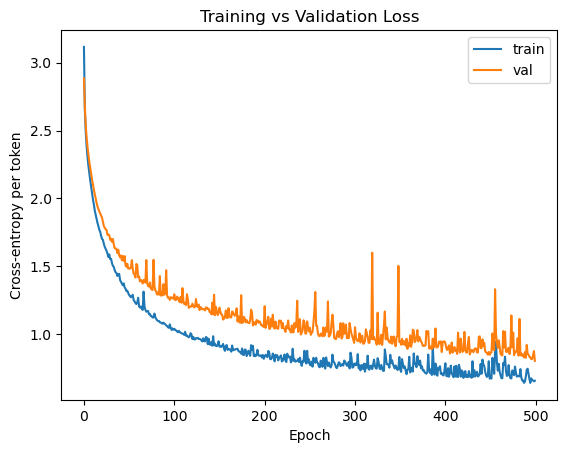

In [31]:
import matplotlib.pyplot as plt
plt.plot(info["train_losses"], label="train")
plt.plot(info["val_losses"], label="val")
plt.legend()
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Cross-entropy per token")
plt.show()

In [32]:
retrieve_with_embeddings(query_idx=10, top_k=5)

Query snippet 10, song_id=0
  file=A. Baker Sweet Love.mid

Top 5 neighbors by embedding cosine similarity:
  idx=28122, song_id=727, file=Blame It on the Boogie.mid, sim=1.000
  idx=28129, song_id=727, file=Blame It on the Boogie.mid, sim=0.989
  idx=  17, song_id=0, file=A. Baker Sweet Love.mid, sim=0.989
  idx=6694, song_id=168, file=don_omar_dile.mid, sim=0.966
  idx=2687, song_id=72, file=dj_sakin_&_friends__protect_your_mind__unknown.mid, sim=0.966
